## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
## First, I'll compute the camera calibration using chessboard images

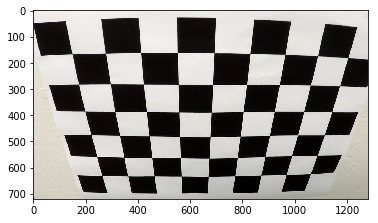

In [34]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib qt
%matplotlib inline
img = mpimg.imread('./camera_cal/calibration2.jpg')
plt.imshow(img)

In [35]:
#undistortion and calibration definition
def cal_undistort(img, objpoints, imgpoints):
    # Use cv2.calibrateCamera() and cv2.undistort()
    #undist = np.copy(img)  # Delete this line
    global ret
    global dist
    global mtx
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    return undist


## And so on and so forth...

True

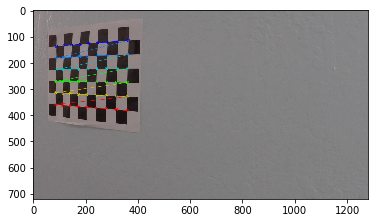

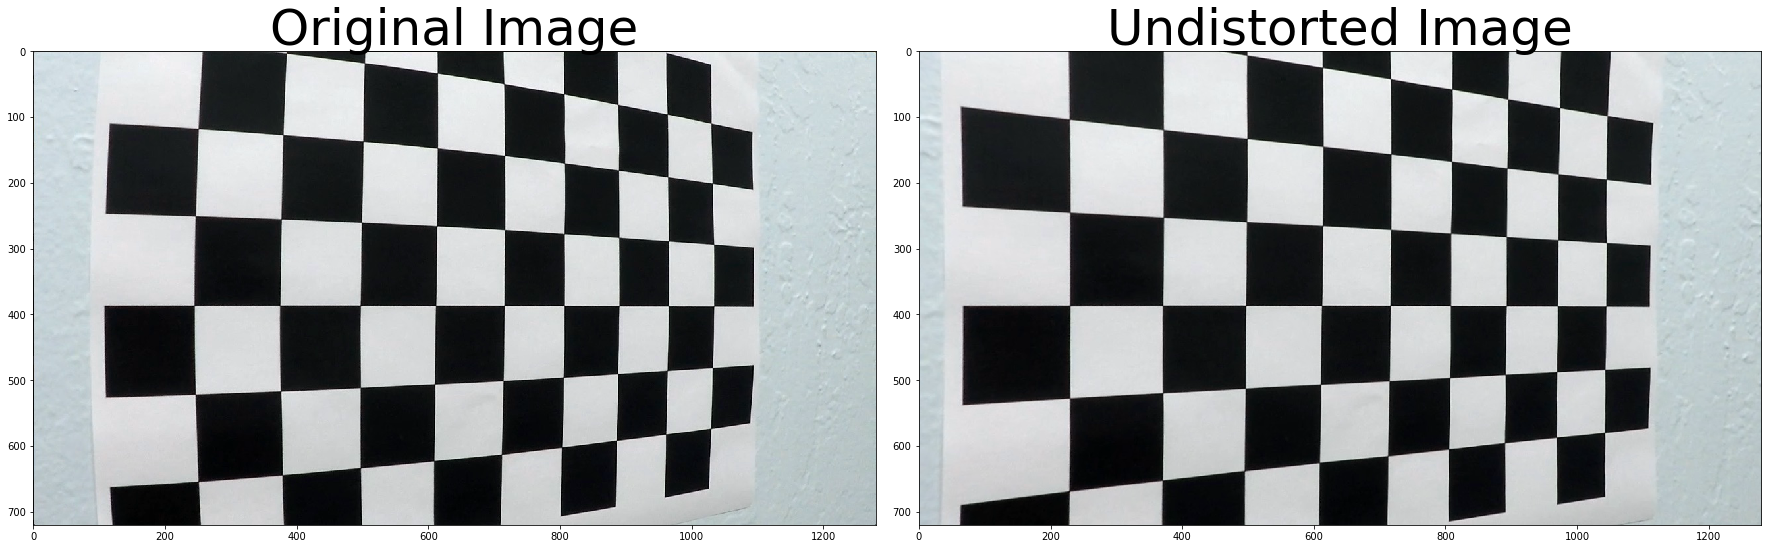

In [36]:
#Chessboard corner and undistortion
# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('./camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
    #print(gray)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)
    #print(ret)
    #print(corners)
    plt.imshow(img)
    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)
        # Draw and display the corners
        img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
        plt.imshow(img)
        #print(objpoints)    

img = cv2.imread('./camera_cal/calibration5.jpg')

undistorted = cal_undistort(img, objpoints, imgpoints)
img_size = (img.shape[1], img.shape[0])
#corners_unwarp(undistorted)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(undistorted)
ax2.set_title('Undistorted Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
cv2.imwrite('./camera_cal/undistorted_calibration5.jpg', undistorted)


In [37]:
#Sobel 
# Define a function that applies Sobel x or y, 
# then takes an absolute value and applies a threshold.
# Note: calling your function with orient='x', thresh_min=20, thresh_max=100
# should produce output like the example image shown above this quiz.
def abs_sobel_thresh(img, orient='x', thresh_min=0, thresh_max=255):
    # Convert to grayscale
    #gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Apply x or y gradient with the OpenCV Sobel() function
    # and take the absolute value
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(img, cv2.CV_64F, 1, 0))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(img, cv2.CV_64F, 0, 1))
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # Create a copy and apply the threshold
    binary_output = np.zeros_like(scaled_sobel)
    # Here I'm using inclusive (>=, <=) thresholds, but exclusive is ok too
    binary_output[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1

    # Return the result
    return binary_output

In [38]:
#Sobel Gradient

# Define a function that applies Sobel x and y, 
# then computes the magnitude of the gradient
# and applies a threshold
def mag_thresh(img, sobel_kernel=9, mag_thresh=(0, 255)):
    
    # Apply the following steps to img
    # 1) Convert to grayscale
    #gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # 2) Take the gradient in x and y separately
    sobelx = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize = sobel_kernel)
    sobely = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize = sobel_kernel)
    # 3) Calculate the magnitude 
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # 4) Scale to 8-bit (0 - 255) and convert to type = np.uint8
    scaled_sobel = (255*gradmag/np.max(gradmag)).astype(np.uint8)
    # 5) Create a binary mask where mag thresholds are met
    sxbinary = np.zeros_like(scaled_sobel)
    thresh_min = mag_thresh[0]
    thresh_max= mag_thresh[1]
    sxbinary[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1
    #plt.imshow(sxbinary, cmap='gray')
    # 6) Return this mask as your binary_output image
    binary_output = sxbinary # Remove this line
    return binary_output
    

In [39]:
#Gradient Direction

# Define a function that applies Sobel x and y, 
# then computes the direction of the gradient
# and applies a threshold.
def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    
    # Apply the following steps to img
    # 1) Convert to grayscale
    
    
    # 2) Take the gradient in x and y separately
    
    sobelx = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize = sobel_kernel)
    sobely = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize = sobel_kernel)
    # 3) Take the absolute value of the x and y gradients
    abs_sobelx = np.absolute(sobelx)
    abs_sobely = np.absolute(sobely)
    # 4) Use np.arctan2(abs_sobely, abs_sobelx) to calculate the direction of the gradient 
    direction = np.arctan2(abs_sobely, abs_sobelx)
    # 5) Create a binary mask where direction thresholds are met
    sxbinary = np.zeros_like(direction)
    sxbinary[(direction >= thresh[0]) & (direction <= thresh[1])] = 1
    # 6) Return this mask as your binary_output image
    binary_output = sxbinary  # Remove this line
    return binary_output

In [40]:
#Perspective Transform
def corners_unwarp(undist):
    #gray = cv2.cvtColor(undist, cv2.COLOR_BGR2GRAY)
    # Choose offset from image corners to plot detected corners
    # This should be chosen to present the result at the proper aspect ratio
    # My choice of 100 pixels is not exact, but close enough for our purpose here
    offset = 80# offset for dst points
    # Grab the image shape
    img_size = (undist.shape[1], undist.shape[0])
    nx = 9
    global M
    # For source points I'm grabbing the outer four detected corners
   
    # For destination points, I'm arbitrarily choosing some points to be
    # a nice fit for displaying our warped result 
    # again, not exact, but close enough for our purposes
   
    src = np.float32(
    [[280,  700],  # Bottom left
     [595,  460],  # Top left
     [715,  460],  # Top right
     [1105, 700]]) # Bottom right

    dst = np.float32(
    [[250,  720],  # Bottom left
     [250,    0],  # Top left
     [1065,   0],  # Top right
     [1065, 720]]) # Bottom right   
    
    height = image.shape[0]
    width = image.shape[1]

    # Given src and dst points, calculate the perspective transform matrix
    M = cv2.getPerspectiveTransform(src, dst)
    # Warp the image using OpenCV warpPerspective()
    warped = cv2.warpPerspective(undist, M, img_size,flags=cv2.INTER_LINEAR)
    #print(M)
     # Compute the inverse perspective transfor also by swapping the input parameters
    Minv = cv2.getPerspectiveTransform(dst, src)
    # Return the resulting image and matrix
    return warped, M, Minv


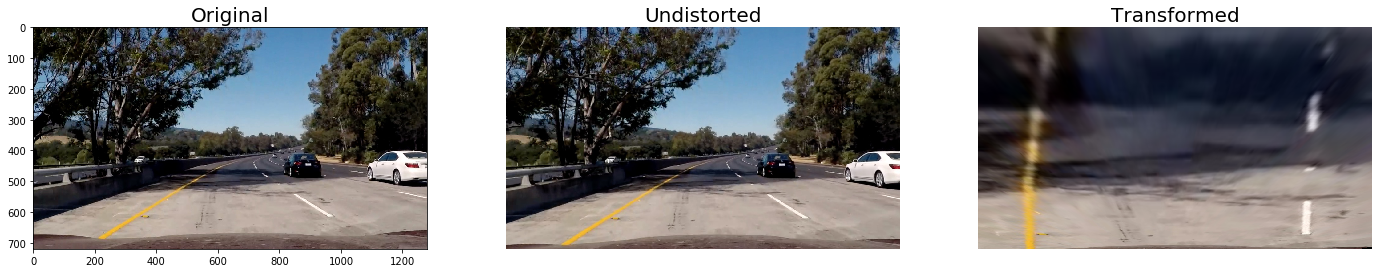

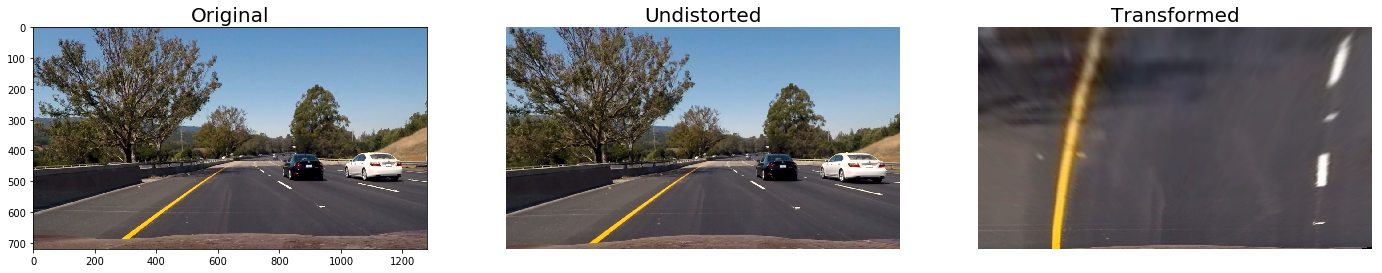

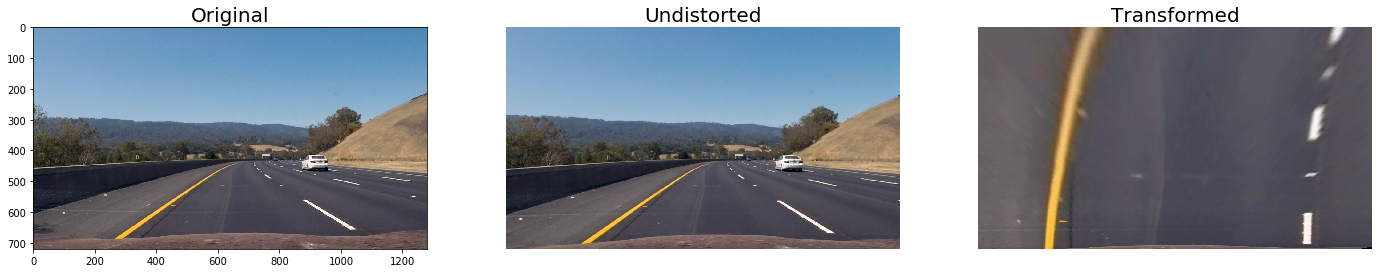

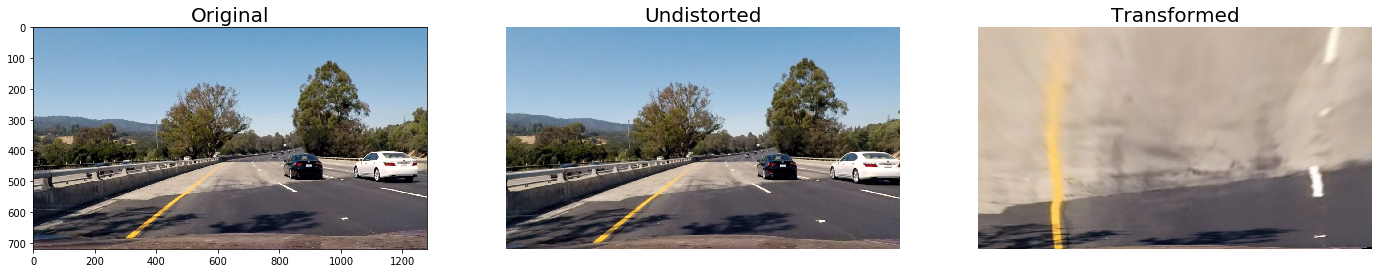

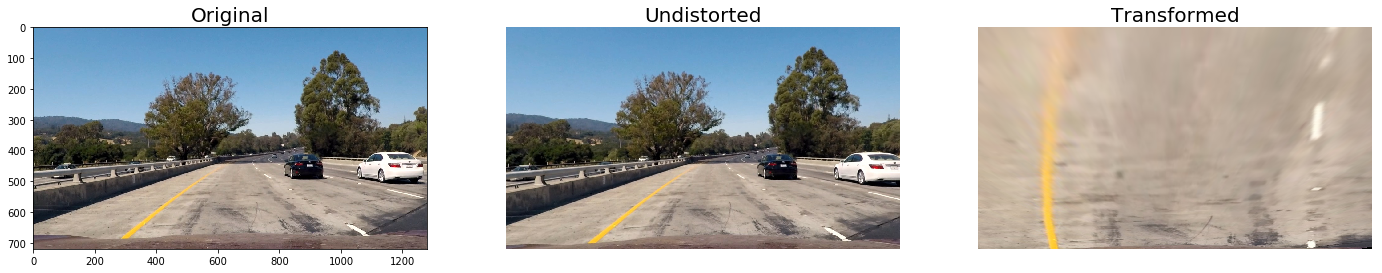

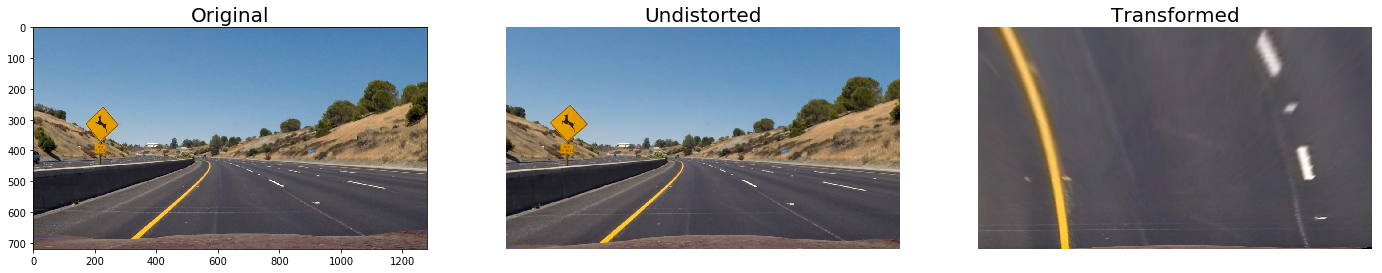

In [41]:
for image in glob.glob('./test_images/test*.jpg'):
    image = mpimg.imread(image)
    undistorted = cal_undistort(image, objpoints, imgpoints)
    transformed, M,Minv = corners_unwarp(undistorted) 
    
    _, (x1, x2, x3) = plt.subplots(1, 3, figsize=(24, 9))
    x1.axis('on')
    x1.imshow(image)
    x1.set_title('Original', fontsize=20)

    x2.axis('off')
    x2.imshow(undistorted)
    x2.set_title('Undistorted', fontsize=20)
    cv2.imwrite('./test_images/undistorted_test*.jpg', undistorted)
    
    x3.axis('off')
    x3.imshow(transformed)
    x3.set_title('Transformed', fontsize=20)
    cv2.imwrite('./test_images/transformed_test*.jpg', transformed)

In [42]:
def hist(img):
    # Grab only the bottom half of the image
    # Lane lines are likely to be mostly vertical nearest to the car
    bottom_half = img[img.shape[0]//2:,:]

    # Sum across image pixels vertically - make sure to set an `axis`
    # i.e. the highest areas of vertical lines should be larger values
    histogram = np.sum(bottom_half, axis=0)
    
    return histogram

In [43]:
def findedges(image):
    hls = cv2.cvtColor(np.copy(image), cv2.COLOR_RGB2HLS).astype(np.float)
    # Separate and get the S channel
    image_hls = hls[:, :, 2]
    thresh = (100, 200)
    g_mask = np.zeros_like(image_hls)
    color_threshold = 150
    R = img[:,:,0]
    G = img[:,:,1]
    color_combined = np.zeros_like(R)
    r_g_condition = (R > color_threshold) & (G > color_threshold)
    
    gradx = abs_sobel_thresh(image_hls, orient='x', thresh_min = 20, thresh_max =100)
    grady = abs_sobel_thresh(image_hls, orient='y', thresh_min = 50, thresh_max =200)
    mag_binary = mag_thresh(image_hls, sobel_kernel=15, mag_thresh=(50, 200))
    dir_binary = dir_threshold(image_hls, sobel_kernel=3, thresh=(np.pi/6, np.pi/2))
    g_mask[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))&(r_g_condition==1)] = 1
    test = g_mask[(image_hls > thresh[0]) & (image_hls <= thresh[1])] = 1
    return g_mask, test

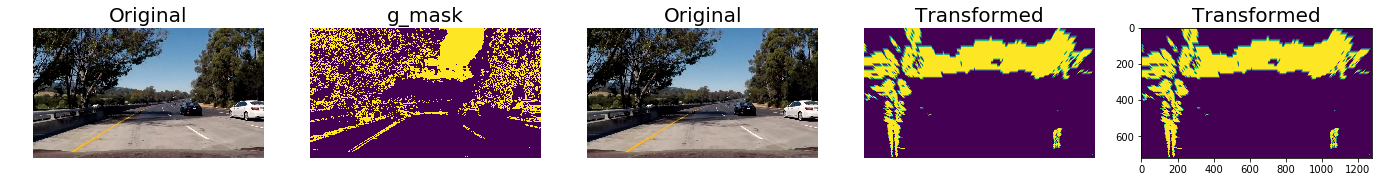

In [56]:
for image in glob.glob('./test_images/test5.jpg'):
    image = mpimg.imread(image)
    hls = cv2.cvtColor(np.copy(image), cv2.COLOR_RGB2HLS).astype(np.float)
    # Separate and get the S channel
    image_hls = hls[:, :, 2]
    thresh = (100, 200)
    g_mask = np.zeros_like(image_hls)
    color_threshold = 150
    R = img[:,:,0]
    G = img[:,:,1]
    color_combined = np.zeros_like(R)
    r_g_condition = (R > color_threshold) & (G > color_threshold)
    
    gradx = abs_sobel_thresh(image_hls, orient='x', thresh_min = 20, thresh_max =100)
    grady = abs_sobel_thresh(image_hls, orient='y', thresh_min = 50, thresh_max =200)
    mag_binary = mag_thresh(image_hls, sobel_kernel=15, mag_thresh=(50, 200))
    dir_binary = dir_threshold(image_hls, sobel_kernel=3, thresh=(np.pi/6, np.pi/2))
    g_mask[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))&(r_g_condition==1)] = 1
    test = g_mask[(image_hls > thresh[0]) & (image_hls <= thresh[1])] = 1
    
    f, (x1, x2, x3,x4,x5) = plt.subplots(1, 5, figsize=(24, 9))
    x1.axis('off')
    x1.imshow(image)
    x1.set_title('Original', fontsize=20)

    ''''x2.axis('off')
    x2.imshow(g_mask)
    x2.set_title('Grad X', fontsize=20)
    
    x3.axis('off')
    x3.imshow(grady)
    x3.set_title('Grad Y', fontsize=20)
    
    x4.axis('off')
    x4.imshow(mag_binary)
    x4.set_title('Mag Binary', fontsize=20)
    
    x5.axis('off')
    x5.imshow(dir_binary)
    x5.set_title('Dir Binary', fontsize=20)'''
    
    x2.axis('off')
    x2.imshow(g_mask)
    x2.set_title('g_mask', fontsize=20)
    masked = g_mask
    cv2.imwrite('./test_images/masked.png', masked)
    
    transformed,M,Minv = corners_unwarp(g_mask) 
    
   
    x3.axis('off')
    x3.imshow(image)
    x3.set_title('Original', fontsize=20)

    x4.axis('off')
    x4.imshow(transformed)
    x4.set_title('Transformed', fontsize=20)
    binary_warped = transformed
    
    #out_img = find_lane_pixels(transformed)

    #plt.imshow(out_img)
    
    x5.axis('on')
    x5.imshow(binary_warped)
    x5.set_title('Transformed', fontsize=20)


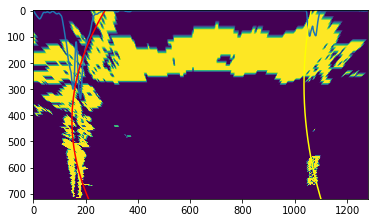

In [45]:


def find_lane_pixels(binary_warped):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    plt.plot(histogram)
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 5
    # Set the width of the windows +/- margin
    margin = 200
    # Set minimum number of pixels found to recenter window
    minpix = 50

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),
        (win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),
        (win_xright_high,win_y_high),(0,255,0), 2) 
        
        
        # Identify the nonzero pixels in x and y within the window #
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return leftx, lefty, rightx, righty, out_img


def fit_polynomial(binary_warped):
    # Find our lane pixels first
    leftx, lefty, rightx, righty, out_img = find_lane_pixels(binary_warped)

    # Fit a second order polynomial to each using `np.polyfit`
    global left_fit
    global right_fit
    global left_fitx
    global right_fitx
    global ploty
    if (lefty.size == 0 or righty.size == 0):
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty
    else:
        left_fit = np.polyfit(lefty, leftx, 2)
        right_fit = np.polyfit(righty, rightx, 2)

        # Generate x and y values for plotting
        ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
        try:
            left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
            right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
        except TypeError:
            # Avoids an error if `left` and `right_fit` are still none or incorrect
            print('The function failed to fit a line!')
            left_fitx = 1*ploty**2 + 1*ploty
            right_fitx = 1*ploty**2 + 1*ploty

    ## Visualization ##
    # Colors in the left and right lane regions
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]

    # Plots the left and right polynomials on the lane lines
    plt.plot(left_fitx, ploty, color='red')
    plt.plot(right_fitx, ploty, color='yellow')

    return out_img


out_img = fit_polynomial(binary_warped)
cv2.imwrite('./test_images/binary_warped.jpg', out_img)


plt.imshow(out_img)
plt.imshow(binary_warped)

[217 218 219 ..., 183 184 185]
[  0   0   0 ..., 714 714 714]


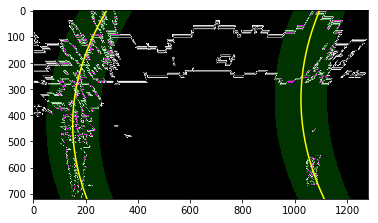

In [46]:
def fit_poly(img_shape, leftx, lefty, rightx, righty):
     ### TO-DO: Fit a second order polynomial to each with np.polyfit() ###
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    # Generate x and y values for plotting
    ploty = np.linspace(0, img_shape[0]-1, img_shape[0])
    ### TO-DO: Calc both polynomials using ploty, left_fit and right_fit ###
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    return left_fitx, right_fitx, ploty
global leftx
global lefty
global rightx
global righty

def search_around_poly(binary_warped):
    # HYPERPARAMETER
    # Choose the width of the margin around the previous polynomial to search
    # The quiz grader expects 100 here, but feel free to tune on your own!
    margin = 100
    global leftx
    global lefty
    global rightx
    global righty


    # Grab activated pixels
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    ### TO-DO: Set the area of search based on activated x-values ###
    ### within the +/- margin of our polynomial function ###
    ### Hint: consider the window areas for the similarly named variables ###
    ### in the previous quiz, but change the windows to our new search area ###
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
                    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
                    left_fit[1]*nonzeroy + left_fit[2] + margin)))
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
                    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
                    right_fit[1]*nonzeroy + right_fit[2] + margin)))
    
    # Again, extract left and right line pixel positions

    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    print(leftx)
    print(lefty)
   

    # Fit new polynomials
    left_fitx, right_fitx, ploty = fit_poly(binary_warped.shape, leftx, lefty, rightx, righty)
    
    ## Visualization ##
    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    window_img = np.zeros_like(out_img)
    # Color in left and right line pixels
    #out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    #out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                              ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                              ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    
    # Plot the polynomial lines onto the image
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    ## End visualization steps ##
    
    return result

# Run image through the pipeline
# Note that in your project, you'll also want to feed in the previous fits
result = search_around_poly(binary_warped)

# View your output
plt.imshow(result)

In [47]:
def measure_curvature_pixels(ploty, left_fit, right_fit):
    '''
    Calculates the curvature of polynomial functions in pixels.
    '''
    # Start by generating our fake example data
    # Make sure to feed in your real data instead in your project!
    #ploty, left_fit, right_fit = generate_data()
    
    # Define y-value where we want radius of curvature
    # We'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty)
    
    # Calculation of R_curve (radius of curvature)
    left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
    right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
    
    return left_curverad, right_curverad

left_curverad, right_curverad = measure_curvature_pixels(ploty, left_fit, right_fit)

print(left_curverad, right_curverad)


900.629171389 1666.38341492


In [48]:
def curvature_radius (leftx, rightx, img_shape, xm_per_pix=3.7/800, ym_per_pix = 25/720):
    ploty = np.linspace(0, img_shape[0] - 1, img_shape[0])
    
    leftx = leftx[::-1]  # Reverse to match top-to-bottom in y
    rightx = rightx[::-1]  # Reverse to match top-to-bottom in y
    
    # Fit a second order polynomial to pixel positions in each fake lane line
    left_fit = np.polyfit(ploty, leftx, 2)
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fit = np.polyfit(ploty, rightx, 2)
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 25/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/800 # meters per pixel in x dimension

    # Fit new polynomials to x,y in world space
    y_eval = np.max(ploty)
    left_fit_cr = np.polyfit(ploty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, rightx*xm_per_pix, 2)
    
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    
    # Now our radius of curvature is in meters
    return (left_curverad, right_curverad)

In [49]:
''''# STEP 8: CALCULATE OFFSET DISTANCE AND ROAD CURVATURE

# Run the function
curvature_rads = curvature_radius(leftx=left_points[0], rightx=right_points[0], img_shape = image.shape)

# Print the results
print('Left line curvature:', curvature_rads[0], 'm')
print('Right line curvature:', curvature_rads[1], 'm')'''

"'# STEP 8: CALCULATE OFFSET DISTANCE AND ROAD CURVATURE\n\n# Run the function\ncurvature_rads = curvature_radius(leftx=left_points[0], rightx=right_points[0], img_shape = image.shape)\n\n# Print the results\nprint('Left line curvature:', curvature_rads[0], 'm')\nprint('Right line curvature:', curvature_rads[1], 'm')"

True

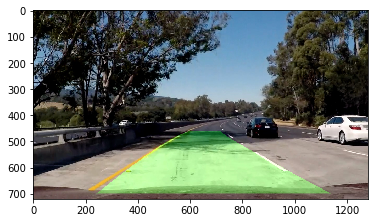

In [50]:

# Create an image to draw the lines on
warp_zero = np.zeros_like(transformed).astype(np.uint8)
color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

# Recast the x and y points into usable format for cv2.fillPoly()
pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
pts = np.hstack((pts_left, pts_right))

# Draw the lane onto the warped blank image
cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

# Warp the blank back to original image space using inverse perspective matrix (Minv)
newwarp = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0])) 
# Combine the result with the original image
result = cv2.addWeighted(image, 1, newwarp, 0.3, 0)
plt.imshow(result)
cv2.imwrite('./test_images/plotted_road.jpg',result)

In [51]:

# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [52]:
# Define a class to receive the characteristics of each line detection
class Line():
    #def __init__(self, frame):
        
        #plt.imshow(result)
    def process_image(self,frame):
        edges,_ = findedges(frame)
        transformed ,_,_ = corners_unwarp(edges)
        out_img = fit_polynomial(transformed)
        #result = search_around_poly(out_img)
        # Create an image to draw the lines on
        warp_zero = np.zeros_like(transformed).astype(np.uint8)
        color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

        # Recast the x and y points into usable format for cv2.fillPoly()
        pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
        pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
        pts = np.hstack((pts_left, pts_right))

        # Draw the lane onto the warped blank image
        cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

        # Warp the blank back to original image space using inverse perspective matrix (Minv)
        newwarp = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0])) 
        # Combine the result with the original image
        left_curverad, right_curverad = measure_curvature_pixels(ploty, left_fit, right_fit)
        #cv2.putText(frame, 'Radius in pixels- Left ' + left_curverad,(0,0) ,cv2.FONT_HERSHEY_DUPLEX, 0.8, (255, 255, 255), 2)
        #cv2.putText(frame, 'Radius in pixels- Right ' + right_curverad,(0,10) ,cv2.FONT_HERSHEY_DUPLEX, 0.8, (255, 255, 255), 2)
        result_1 = cv2.addWeighted(frame, 1, newwarp, 0.3, 0)
        return result_1
    
        ''''# was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None  '''

In [53]:

def apply_video(input_video, output_video):

    # Process video frames with our 'process_image' function
    
    lineInstance = Line()
    
    ## You may uncomment the following line for a subclip of the first 5 seconds
    #clip1 = VideoFileClip(input_video).subclip(0,5)
    clip1 = VideoFileClip(input_video)
    white_clip = clip1.fl_image(lineInstance.process_image)
    %time white_clip.write_videofile(output_video, audio=False)
    
    print("Apply video pipeline: SUCCESS!")

[MoviePy] >>>> Building video ../project_video_output.mp4
[MoviePy] Writing video ../project_video_output.mp4


100%|█████████▉| 1260/1261 [06:32<00:00,  3.13it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ../project_video_output.mp4 

CPU times: user 4min 29s, sys: 3.15 s, total: 4min 32s
Wall time: 6min 35s
Apply video pipeline: SUCCESS!


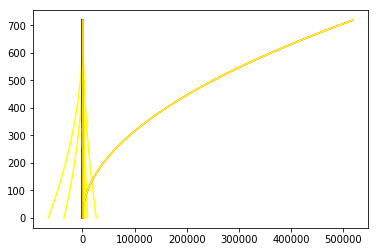

In [38]:
input_video = './project_video.mp4'
output_video = './project_video_output.mp4'

apply_video(input_video, output_video)